In [1]:
%matplotlib inline
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas import Series, DataFrame
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

#### The records could not be decoded using UTF-8, UTF-16, or UTF-32 encoding schemes. They were successfully decoded using ISO-8859-16 (Latin-10), which is an extended version of Latin-1. ISO-8859-16 covers a set of characters used in European languages and other regions.


In [2]:
df = pd.read_csv('/Users/anilthapa/ML_Project/data/tweet.csv', encoding='ISO-8859-16')

In [3]:
df.shape

(9093, 3)

We see a whole lot of missing values in `emotion_in_tweet_is_directed_at` columns. However, in our `tweet_text` column there is only one missing values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
df.columns =['tweet', 'device', 'emotion']

There is four category of emotions, of which the three is pretty straightforward. But there is also an extra category in there that does not reflect the emotion at all. Lets delve to find out what we can do with '`I can't tell`' category

In [7]:
df['emotion'].unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

Given that our total record size is (9093, 3) the emotion with "`I can't tell`" category only occupies about 156 rows which is about 1.7 % of total record, which we can drop it. Given that our main classification goal is to predict emotion of a tweet, for now we will just drop it and only focus on the three category of emotions.

Just an overview our tweet with where there is "`I can't tell`" category. 

In [8]:
df[df['emotion'] == "I can't tell"]

,tweet,device,emotion
90,Thanks to @mention for publishing the news of ...,NaN,I can't tell
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell
237,Just what America needs. RT @mention Google to...,NaN,I can't tell
341,The queue at the Apple Store in Austin is FOUR...,NaN,I can't tell
368,Hope it's better than wave RT @mention Buzz is...,NaN,I can't tell
...,...,...,...
9020,It's funny watching a room full of people hold...,NaN,I can't tell
9032,"@mention yeah, we have @mention , Google has n...",NaN,I can't tell
9037,"@mention Yes, the Google presentation was not ...",NaN,I can't tell
9058,&quot;Do you know what Apple is really good at...,NaN,I can't tell


Here we only include the records with just three emotion

In [9]:
df = df[df['emotion'] !="I can't tell"]

In [10]:
df['emotion'].unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product'], dtype=object)

Taking only '`tweet`' and '`emotion`' column into consideration because, '`device`' column contains a lot of null values (approximately 64 % null values of total records). And, our domain knowledge tells us that the device they tweet do not have significant impact on the sentiment of the tweet.

In [11]:
df = df[['tweet', 'emotion']]

Earlier, we found out that our '`tweet`' column contain only one null values, let us see the record and drop it.

In [12]:
df[df.isnull().any(axis = 1)]

,tweet,emotion
6,NaN,No emotion toward brand or product


In [13]:
df.dropna(inplace=True)

In [14]:
df.isna().any()

tweet      False
emotion    False
dtype: bool

In [15]:
df.groupby('emotion').count()

,tweet
emotion,
Negative emotion,570
No emotion toward brand or product,5388
Positive emotion,2978


Here, our dataset seems to be imbalanced. The lowest number of records is `negative emotion` which is approximately 6 % of the total dataset, while `neutral emotion` is dominant class with approximately 60 % of the dataset.

Here, we create a method to preprocess the columns, such as remove all the puncutations, remove special characters and then convert them all to lowercase.

In [16]:
def preprocess_text(text):
    if isinstance(text, str):
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove special characters and symbols
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        text = text.lower()
    return text

In [17]:
df['tweet']= DataFrame(df['tweet'].apply(preprocess_text))

### Train, Test Split

In [18]:
X, y = df['tweet'], df['emotion']

In [19]:
X.shape

(8936,)

### Using Count Vectorizer 
`CountVectorizer` is a feature extraction technique provided by scikit-learn. It is used to convert a collection of text documents into a matrix of token counts. Here's how it works:
- `Tokenization` breaks down each document into indviduals words or terms. The process is called tokenization.
- `Counting` It counts the occurences of each word in each document. The result is a matrix where each row represents a document, and each column represents a word, with the cell value indicating how many times the word appear in the document.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
count_vectorizer = CountVectorizer()

In [22]:
X = count_vectorizer.fit_transform(X)

In [23]:
X

<8936x10743 sparse matrix of type '<class 'numpy.int64'>'
	with 142875 stored elements in Compressed Sparse Row format>

In [24]:
X = X.toarray()

In [25]:
X.shape

(8936, 10743)

In [26]:
#for i in count_vectorizer.get_feature_names_out():
#    print(i)

In [27]:
from sklearn.preprocessing import LabelEncoder

In [28]:
encoder = LabelEncoder()

In [29]:
y = encoder.fit_transform(y)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

### Import and Train the Model

### Multinomial NB using Count Vectorizer

### Random Over Sampling

In [32]:
ros = RandomOverSampler(random_state = 42)

In [33]:
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [34]:
from sklearn.naive_bayes import MultinomialNB

In [35]:
multinomial_NB = MultinomialNB()

In [36]:
multinomial_NB.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

In [37]:
y_predict_mn = multinomial_NB.predict(X_test)

### Metrics

In [38]:
y_predict_mn.shape

(1788,)

In [39]:
y_test.shape

(1788,)

In [40]:
accuracy = accuracy_score(y_test, y_predict_mn)
print('Accuracy Score: ', accuracy)

Accuracy Score:  0.6180089485458613


In [41]:
c_report = classification_report(y_test, y_predict_mn)
print('Classification report:', c_report)

Classification report:               precision    recall  f1-score   support

           0       0.34      0.56      0.43       126
           1       0.77      0.62      0.69      1094
           2       0.50      0.63      0.56       568

    accuracy                           0.62      1788
   macro avg       0.54      0.60      0.56      1788
weighted avg       0.66      0.62      0.63      1788



Confusion Matrix: [[ 70  33  23]
 [ 87 677 330]
 [ 46 164 358]]


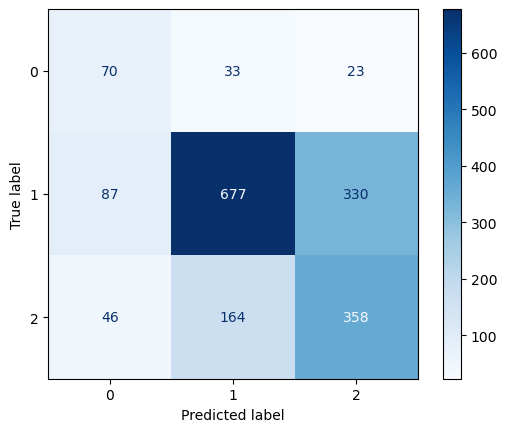

In [42]:
c_matrix_mn = confusion_matrix(y_test, y_predict_mn, labels=multinomial_NB.classes_)
print('Confusion Matrix:', c_matrix_mn)
plt = ConfusionMatrixDisplay(confusion_matrix=c_matrix_mn, display_labels=multinomial_NB.classes_)
plt.plot(cmap='Blues')

### Using Term Frequency - Inverse Document Frequency

`Term Frequency(TF)` - It measures how frequently a term occurs in a document. It is calculated as the number of times a term appears in a document divided by the total number of terms in a document. 

`Inverse Document Frequency(IDF)` - It measures how important a term is accross the entire corpus. It is calculated as the logarithm of the total number of documents divided by the number of documents containing the term. 

In [ ]:
X1, y1 = df['tweet'], df['emotion']

In [ ]:
X1

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer()
X1 = vectorizer.fit_transform(X1)

In [ ]:
X1 = X1.toarray()

In [ ]:
X1.shape

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
y1 = label_encoder.fit_transform(y1)
y1.shape

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, train_size=0.8, random_state=42)

In [ ]:
multinomial_NB_tfidf= MultinomialNB()

In [ ]:
type(X1_train)

In [ ]:
multinomial_NB_tfidf.fit(X1_train, y1_train)

In [ ]:
y_predict_tfidf = multinomial_NB_tfidf.predict(X1_test)

In [ ]:
y_predict_tfidf

### Metrics

In [ ]:
y1_test.shape

In [ ]:
accuracy = accuracy_score(y_test, y_predict_tfidf)
print('Accuracy Score: ', accuracy)

In [ ]:
c_report = classification_report(y_test, y_predict_tfidf)
print('Classification report:', c_report)

In [ ]:
c_matrix_tfidf = confusion_matrix(y_test, y_predict_tfidf, labels=multinomial_NB_tfidf.classes_)
print('Confusion Matrix:', c_matrix_tfidf)
plt = ConfusionMatrixDisplay(confusion_matrix=c_matrix_tfidf, display_labels=multinomial_NB_tfidf.classes_)
plt.plot(cmap='Blues')

Here, we conclude that using `TD-IDF` is slightly better that using `CountVectorizer` while performing our feature extraction.